# Extending fwdpy with Cython functions

Cython makes it easy to [share definitions](http://docs.cython.org/en/latest/src/userguide/sharing_declarations.html) between packages, allowing access fwdpy's types to write custom code.  Further, as fwdpy depends on and installs [fwdpp](https://molpopgen.github.io/fwdpp), you get access to many of that library's features.  Even better, you can write your extensions and ignore a lot of gory details regarding compiling and linking--Cython handles that for you!

This document serves as a rapid-fire tutorial both to the C++ types that underly fwdpy and how to use Cython to write your own extensions.

## Plugins vs. packages

For the most part, Cython code is written in files with the extension .pyx.  If you can write all of your extension in Cython, you may simply compile and import your module into a script using [pyximport](http://cython.readthedocs.io/en/latest/src/reference/compilation.html).  For user's familiar with [Rcpp](http://rcpp.org), think of pyimport as the analog to their `sourceCpp` function.

When using pyximport, the function `fwdpy.make_pyxbld` will help you out a lot--please see its documentation in the reference manual.

If you start writing a lot of extensions or your extensions require C++11 features that Cython cannot handle, then you may want to consider writing a full-blown package for your extensions. There are lots of examples online, from the Cython documentation to how the [fwdpy source code](http://github.com/molpopgen/fwdpy) is organized.

## Linux vs OS X

Due to issues with compiler support on OS X, Linux is the intended platform for using fwdpy. It is possible to install the package on OS Xif you use GCC, which you can install via Anaconda.

When compiling extensions, Python's distutils attempts to force use of the same compiler used to build Python.  On OS X, that means clang, but fwdpy requires GCC on OS X.  Thus, you need to force the use of GCC via the CC/CXX environment variables.

## An important note

Many of the example functions below actually end up replicating things that are already doable in fwdpy.  In other words, you don't need any of the stuff below to do what is below.  These are examples for the point of documenting the C++/Cython API that you have access to.

## Cython 'magic' lines

Every Cython code block in this document begins with a line starting "%%cython".  That's another 'magic' command for the Jupyter notebooks.  It contains info needed to compile each code block.  You can basically ignore that.

# Relevant C++ background

You should be familiar with the following C++ types:

* [std::vector](http://en.cppreference.com/w/cpp/container/vector)
* [std::map](http://en.cppreference.com/w/cpp/container/map)
* [std::pair](http://en.cppreference.com/w/cpp/utility/pair)

In [1]:
#This is a 'magic' command allowing us to 
#use Cython in a Jupyter notebook, which is
#what we use to write this document.
%load_ext Cython

In [2]:
import fwdpy as fp
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Finding the headers
fwdpy provides functions that reveal the locations of both the fwdpy C++ header files and the fwdpp C++ header files that are installed along with fwdpy.  You need to know these locations!

In [3]:
fwdpy_includes = fp.get_includes()
fwdpp_includes = fp.get_fwdpp_includes()

# Example 1: the site-frequency spectrum of all mutations

The first function that we will write will calculate the site-frequency-spectrum (SFS) of the entire population.  We impose the following constraints to keep things simple:

* We will only process single-deme objects (type fwdpy.Spop).

On to our code for the SFS:

In [4]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas
#Import all Cython symbols defined
#in fwdpy's main module
from fwdpy.fwdpy cimport *
import numpy as np
#Now, we define a C++ function that:
#1. Takes the C++ representation as an argument
#2. Returns a C++ vector of unsigned integers
cdef vector[unsigned] sfs_cpp(const singlepop_t * pop):
    #declare our return value.
    #This is a standard C++ vector.
    #The C++ vector is imported as a 
    #side-effect of cimporting fwdpp's
    #Cython API
    cdef vector[unsigned] rv
    #For a population of N diploids,
    #there are N bins in the SFS 
    #(including fixations, which
    #we don't deal with here).
    #So we initialize the return
    #value to 2N zeroes
    rv.resize(2*pop.N,0)
    
    #i is a dummy variable
    cdef size_t i = 0
    #A population contains a 
    #vector[unsigned] that represents
    #the count (no. occurrences) of
    #every mutation.  Warning: it also
    #conatains mutations with a count of
    #0 (zero) because fwdpp internally
    #puts new variants in those spaces...
    for i in range(pop.mcounts.size()):
        #...so we check that
        #a mutation's count
        #is nonzero...
        if pop.mcounts[i]>0:
            #...and increment our return value
            #accordingly.
            rv[pop.mcounts[i]-1]+=1
    #Return the SFS to Python
    return rv

def sfs(Spop pop):
    """
    This is the Python function that will return the 
    SFS for a fwdpy.Spop object.
    
    Note that we can specify the argument type in the
    "def" line.  
    
    This docstring can be processed by Sphinx, and so
    we use Sphinx grammar for documenting the params,
    and we make sure to provide a link to the documentation
    of the parameter's expected type:
    
    :param pop: A :class:`fwdpy.fwdpy.Spop`
    
    :return: The site-frequency spectrum for pop
    
    :rtype: numpy.array with dtype numpy.uint32
    """
    #Here, we call our Cython function.
    #The fwdpy.Spop type contains a
    #std::shared_ptr[singlepop_t] object
    #called "pop".  So, we send the raw pointer
    #to our Cython function:
    return np.array(sfs_cpp(pop.pop.get()),dtype=np.uint32)

In [5]:
N=1000
theta=100.
nlist=np.array([N]*(10*N),dtype=np.uint32)
rng = fp.GSLrng(135123)
nregions=[fp.Region(0,1,1)]
sregions=[]
recregions=nregions
#Simulate 10 populations
pops = fp.evolve_regions(rng,10,N,nlist,theta/(4.*float(N)),0.,theta/(4.*float(N)),nregions,sregions,recregions)

In [6]:
sfs_pop=sfs(pops[0])
print(sfs_pop[0:10])
print(type(sfs_pop))

[106  49  40  37  14  16  11  16   2   4]
<type 'numpy.ndarray'>


Get the mean SFS for our 10 replicates:

In [7]:
mean_sfs = np.sum([sfs(i) for i in pops],axis=0)/10.
mean_sfs

array([ 109. ,   50.1,   36.5, ...,    0. ,    0. ,    0. ])

## Pythonic or not?

The `sfs_cpp` function takes a const pointer for an argument.  If we relax that constraint, we can write some of the details in a more relaxed, Pythonic manner:

In [8]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas
from fwdpy.fwdpy cimport *
import numpy as np
#A non-const pointer now:
cdef vector[unsigned] sfs_cpp_pythonic(singlepop_t * pop):
    cdef vector[unsigned] rv
    rv.resize(2*pop.N,0)
    cdef size_t i = 0
    #When operating in a non-const
    #context, you can use 
    #Python-like syntax
    #to iterate over C++
    #containers:
    for i in pop.mcounts:
        if i>0:
            rv[i-1]+=1
    return rv

def sfs_pythonic(Spop pop):
    """
    This is another Python function that will return the 
    SFS for a fwdpy.Spop object.
    
    :param pop: A :class:`fwdpy.fwdpy.Spop`
    
    :return: The site-frequency spectrum for pop
    
    :rtype: numpy.array with dtype numpy.uint32
    """
    return np.array(sfs_cpp_pythonic(pop.pop.get()),dtype=np.uint32)

We get the same results:

In [9]:
mean_sfs = np.sum([sfs_pythonic(i) for i in pops],axis=0)/10.
mean_sfs

array([ 109. ,   50.1,   36.5, ...,    0. ,    0. ,    0. ])

Why would you use the more complex first method?  From a C++ purist's perspective, the latter function protoype (with the non-const pointer argument) is annoying.  While the function does not modify the input value, but you cannot know that without reading its implementation in detail.  Personally, I like having the function fail to compile if I accidentally try to modify a constant object.

## Raw pointer vs shared_ptr?

C++11 programmers will note that I'm passing a raw pointer to the SFS function.  We could just as easily pass a const reference to the smart pointer.  If we do that, we have to understand that Cython does not distinguish the C++ -> and . (period) operators, which is tricky for us.  When using a C++ smart pointer, -> gives member access to the pointer's ata while the period (.) operator gives access to the smart pointer's data and/or member functions.  The solution is we must allways use the smart pointer's `get()` member function and trust in our compiler to optimize it away:

In [12]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas
from fwdpy.fwdpy cimport *
import numpy as np

#Pass in the shared_ptr as a const reference:
cdef vector[unsigned] sfs_cpp_shared_ptr(const shared_ptr[singlepop_t] & pop):
    cdef vector[unsigned] rv
    #Have to use get
    rv.resize(2*pop.get().N,0)
    cdef size_t i = 0
    #have to use get
    for i in pop.get().mcounts:
        if i>0:
            rv[i-1]+=1
    return rv

def sfs_shared_ptr(Spop pop):
    """
    This is another Python function that will return the 
    SFS for a fwdpy.Spop object.
    
    :param pop: A :class:`fwdpy.fwdpy.Spop`
    
    :return: The site-frequency spectrum for pop
    
    :rtype: numpy.array with dtype numpy.uint32
    """
    return np.array(sfs_cpp_shared_ptr(pop.pop),dtype=np.uint32)

Ultimately, it is up to you which you prefer.  However, it is non-obvious that all compilers will optimize away all calls to `get()`.

Of course, we get the same answer:

In [13]:
mean_sfs = np.sum([sfs_shared_ptr(i) for i in pops],axis=0)/10.
mean_sfs

array([ 109. ,   50.1,   36.5, ...,    0. ,    0. ,    0. ])

### Caveat: future API changes

One weakness of passing in the `shared_ptr` is that we may consider changing the `shared_ptr` to `unique_ptr` in the future.  Such a change is transparent to all of our previous function, but `sfs_cpp_shared_ptr` would be affected by the API change.

## Getting the SFS from fwdpy

Remember, the above code replicates existing fwdpy features.  To get the SFS, use "views" of the mutations in your simulation:

In [14]:
mean_sfs_views = np.array([0.]*2*N)
for v in fp.view_mutations(pops):
    for m in v:
        mean_sfs_views[m['n']-1]+=1
mean_sfs_views /= 10.
mean_sfs_views

array([ 109. ,   50.1,   36.5, ...,    0. ,    0. ,    0. ])

# Separating the neutral and selected SFS

In [15]:
#Now simulated selected variants
sregions=[fp.GammaS(0,1,0.9,-0.043,0.23,1),
         fp.ExpS(0,1,0.1,0.01,1)]
theta_selected = 0.1*theta
#Re-simulate 10 populations
pops = fp.evolve_regions(rng,10,N,nlist,theta/(4.*float(N)),theta_selected/(4.*float(N)),theta/(4.*float(N)),nregions,sregions,recregions)

In [16]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas
#Import all Cython symbols defined
#in fwdpy's main module
from fwdpy.fwdpy cimport *
from libcpp.utility cimport pair
import numpy as np

ctypedef vector[unsigned] vu
ctypedef pair[vu,vu] pvuvu

cdef pvuvu sfs_sep_cpp(const singlepop_t * pop):
    cdef pvuvu rv
    rv.first.resize(2*pop.N,0)
    rv.second.resize(2*pop.N,0)
    cdef size_t i = 0
    for i in range(pop.mcounts.size()):
        if pop.mcounts[i]>0:
            #Populations store their mutations
            #in a vector. A mutation
            #contains a boolean recording its
            #"neutrality":
            if pop.mutations[i].neutral is True:
                #The first element will be the
                #neutral SFS
                rv.first[pop.mcounts[i]-1]+=1
            else:
                #The second will be the selected
                #SFS
                rv.second[pop.mcounts[i]-1]+=1
    #Return the SFS to Python.
    #Cython auto-converts the
    #pair of vectors to a 
    #tuple of lists
    return rv

def sfs_sep(Spop pop):
    """
    This is the Python function that will return the 
    SFS for a fwdpy.Spop object.  The sfs will be 
    separate for neutral variants
    
    :param pop: A :class:`fwdpy.fwdpy.Spop`
    
    :return: The site-frequency spectrum for pop, separating
    neutral and selected variants
    
    :rtype: tuple of numpy.array with dtype numpy.uint32
    """
    return np.array(sfs_sep_cpp(pop.pop.get()),dtype=np.uint32)

Let's apply our new function and get the mean normalized SFS for neutral and selected variants.

In [17]:
pop_sfs_sep = [sfs_sep(i) for i in pops]
#Note that we need to cast one array from uint32 to float,
#so that numpy promotes the calculation to floating-point.
mean_norm_sfs_neut = np.sum([i[0].astype(np.float)/np.sum(i[0]) for i in pop_sfs_sep],axis=0) / float(len(pops))
mean_norm_sfs_sel = np.sum([i[1].astype(np.float)/np.sum(i[1]) for i in pop_sfs_sep],axis=0) / float(len(pops))
print(mean_norm_sfs_neut)
print(mean_norm_sfs_sel)

[ 0.18459531  0.07918477  0.06201459 ...,  0.          0.          0.        ]
[ 0.22176807  0.08613146  0.07475673 ...,  0.          0.          0.        ]


# The relationship between frequency and "s" (or effect size)

Here, we write a function that returns the frequency of a mutation in the population and its selection coefficient/effect size.

This examples shows off some of Cython's quirks :).

In [18]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas

from fwdpy.fwdpy cimport *
from libcpp.utility cimport pair
import numpy as np

ctypedef vector[double] vd
ctypedef pair[vd,vd] pvdvd

#Annoyingly, Cython currently does not 
#expose std::make_pair, so we will 
#do it here ourselves!
#If we don't have std::make_pair,
#we end up making extra temporary copies
#of our return values in memory.  That's 
#not cool, as we're doing this because
#we care about efficiency!
cdef extern from "<utility>" namespace "std" nogil:
    pair[T,U] make_pair[T,U](T&,U&)

cdef pvdvd freq_esize_cpp(const singlepop_t * pop):
    cdef vd freq,esize
    cdef double twoN = 2.0*float(pop.N)
    cdef size_t i = 0
    cdef size_t nm=0
    for i in range(pop.mcounts.size()):
        if pop.mcounts[i]>0:
            if pop.mutations[i].neutral is False:
                freq.push_back(float(pop.mcounts[i])/twoN)
                #s records the effect size/selection coefficient
                esize.push_back(pop.mutations[i].s)
    #For some reason, we need to provide casts
    #so that Cython can get the types right for the call to
    #make_pair:
    return make_pair(<vd>freq,<vd>esize)

def freq_esize(Spop pop):
    return freq_esize_cpp(pop.pop.get())

Let's get the result for our first population and plot it using matplotlib:

(0, 1)

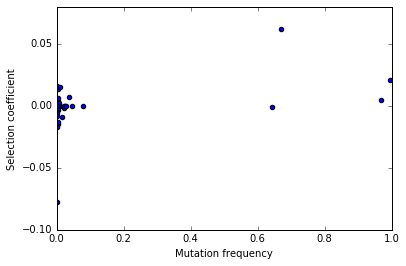

In [19]:
x = freq_esize(pops[0])
x[0]
fig,ax=plt.subplots()
ax.scatter(x[0],x[1])
ax.set_xlabel("Mutation frequency")
ax.set_ylabel("Selection coefficient")
ax.set_xlim(0,1)

# The number of selected mutations per diploid plus fitness of each diploid

In this section, we learn to process diploids.  We take advantage of Cython's automatic C++ map to Python dict conversion for our return value.

The key concepts here are:

1. Diploids are pairs of integers
2. Each integer refers to a gamete in pop.gametes
3. A gamete contains two containers, mutations and smutations, which represent neutral and selected mutations, respectively.

In [20]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas

from fwdpy.fwdpy cimport *
from libcpp.utility cimport pair
from libcpp.string cimport string as cppstring
from libcpp.map cimport map
import numpy as np

ctypedef map[string,double] map_type

cdef vector[map_type] load_fitness_cpp(const singlepop_t * pop):
    #Cython requires C-like declarations,
    #meaning that variables cannot be declared
    #in loop bodies.
    cdef vector[map_type] rv
    cdef size_t i=0
    cdef map_type m
    cdef unsigned n1,n2
    for i in range(pop.N):
        #initialize empty
        #map
        m = map_type()
        #Update the fitness
        m['w'] = pop.diploids[i].w
        #Get no. selected mutations
        #on first gamete. A diploid
        #is modeled after pair[size_t,size_t],
        #with each integer referring to each
        #allele.
        n1 = pop.gametes[pop.diploids[i].first].smutations.size()
        #Same deal for the second
        n2 = pop.gametes[pop.diploids[i].second].smutations.size()
        m['load'] = n1+n2
        rv.push_back(m)
    return rv
    
def load_fitness(Spop pop):
    return load_fitness_cpp(pop.pop.get())

Let's apply the function to the first population and generate histograms from the results:

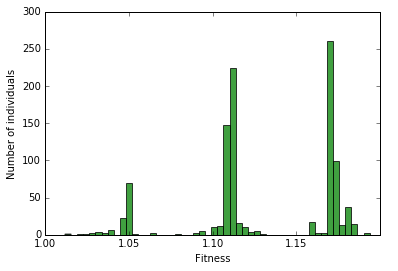

In [21]:
load = load_fitness(pops[0])
n, bins, patches = plt.hist([i['w'] for i in load], 50, normed=0, facecolor='green', alpha=0.75)
plt.xlabel("Fitness")
plt.ylabel("Number of individuals")

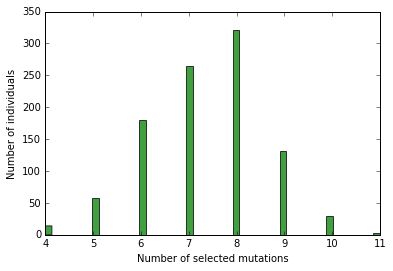

In [22]:
n, bins, patches = plt.hist([i['load'] for i in load], 50, normed=0, facecolor='green', alpha=0.75)
plt.xlabel("Number of selected mutations")
plt.ylabel("Number of individuals")

# The mean effect size of selected mutations on each haplotype in each diploid

In this example, we learn how to access the actual mutations on each diploid.

One thing we learn here is that fwdpy provides a bunch of typedefs for various data objects.  These include:

* diploid_t = a diploid
* gamete_t = a gamete
* gcont_t = vector[gamete_t]
* mutation_t = a mutation
* mcont_t = vector[mutation_t]

In [23]:
%%cython --cplus --compile-args=-std=c++11 -I $fwdpy_includes -I $fwdpp_includes -l sequence -l gsl -l gslcblas

from fwdpy.fwdpy cimport *

#I really should add this to Cython in a PR :)
cdef extern from "<utility>" namespace "std" nogil:
    pair[T,U] make_pair[T,U](T&,U&)

ctypedef vector[pair[double,double]] return_type

#Define a second function to save a bunch of copy/paste
#in our main work function
cdef double get_mean_s(const gamete_t & g,const mcont_t & mutations):
    if g.smutations.empty():
        return 0.
    cdef sum_s=0.
    cdef size_t i
    #The containers in each gametes
    #contain unsigned 32-bit integers
    #referring to locations in the 
    #mutations container
    for i in range(g.smutations.size()):
            sum_s += mutations[g.smutations[i]].s
    return sum_s/<double>g.smutations.size()

cdef return_type mean_s_cpp(const singlepop_t * pop):
    cdef return_type rv
    cdef size_t i
    cdef double m1,m2
    for i in range(pop.diploids.size()):
        m1=get_mean_s(pop.gametes[pop.diploids[i].first],pop.mutations)
        m2=get_mean_s(pop.gametes[pop.diploids[i].second],pop.mutations)
        rv.push_back(make_pair(<double>m1,<double>m2))
    return rv


def mean_s(Spop pop):
    return mean_s_cpp(pop.pop.get())    

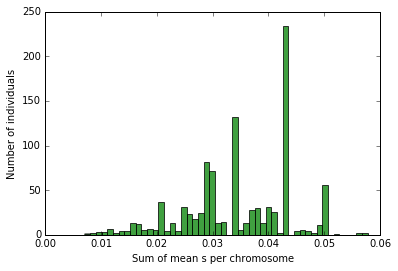

In [24]:
s_per_dip=mean_s(pops[0])
n, bins, patches = plt.hist([i[0]+i[1] for i in s_per_dip], 50, normed=0, facecolor='green', alpha=0.75)
plt.xlabel("Sum of mean s per chromosome")
plt.ylabel("Number of individuals")